In [ ]:
# download the pretrained german language model from floleuerer
# https://github.com/floleuerer/fastai_ulmfit_german
!wget http://meansqua.red/files/de_ulmfit/30k/de_wikitext.pth -P models
!wget http://meansqua.red/files/de_ulmfit/30k/de_wikitext_vocab.pkl -P models

In [2]:
# mount google drive to import files
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# install fast.ai library and other libraries needed for the notebook
!pip install -Uqq fastbook
import fastbook
import pandas as pd
import json
from fastai.text.all import *

     |████████████████████████████████| 727kB 13.2MB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
     |████████████████████████████████| 194kB 53.3MB/s 
     |████████████████████████████████| 1.1MB 52.5MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 


## Load and prepare the Data

In [32]:
path = Path('.')
model_path = Path(f'{path.absolute()}/models')
spm_path = Path(path/'models/spm_de_ft')

In [33]:
lyrics = pd.read_csv("/content/drive/MyDrive/lyrics.csv")
lyrics.drop("Unnamed: 0", axis=1, inplace=True)

In [34]:
# load tokenizer
tok = SentencePieceTokenizer(lang="de", cache_dir=spm_path)
# load data using FastAI's DataBlock API
lyrics_lm = DataBlock(blocks=TextBlock.from_df('lyrics', is_lm=True, tok=tok),
                    get_x=ColReader('text'),
                    splitter=RandomSplitter(0.1))

# create dataloaders
dlsLyrics = lyrics_lm.dataloaders(lyrics, bs=64)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Fine-tune the language model

In [35]:
# initialize the model
pretrained_fnames = ["/content/models/de_wikitext", "/content/models/de_wikitext_vocab"]
learn_lm = language_model_learner(dlsLyrics, AWD_LSTM, drop_mult=0.5, pretrained=True, pretrained_fnames=pretrained_fnames, 
                               metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.0691830962896347)

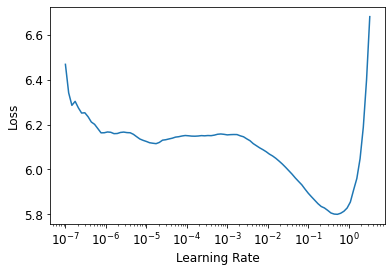

In [36]:
learn_lm.lr_find()

In [37]:
lr = 0.07
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.520968,4.290293,0.282162,72.987831,00:30


In [38]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(15, slice(lr/10,lr), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.917076,4.107571,0.302911,60.798836,00:34
1,3.749273,4.137496,0.295094,62.645729,00:34
2,3.678598,4.193908,0.298701,66.281326,00:34
3,3.632244,4.134302,0.308689,62.445969,00:34
4,3.456254,4.075757,0.317733,58.895050,00:34
5,3.294416,4.064702,0.323124,58.247524,00:34
6,3.083467,4.063488,0.328475,58.176907,00:34
7,2.907091,4.026275,0.337462,56.051739,00:34
8,2.683048,4.027065,0.341370,56.096016,00:34
9,2.420420,4.019886,0.347058,55.694733,00:34


In [39]:
learn_lm.path = model_path

In [40]:
# save the fine-tuned language model
lm_ft_fns = [model_path/"de_ft", model_path/"de_ft_vocab.pkl"]
learn_lm.to_fp32()
learn_lm.save(lm_ft_fns[0], with_opt=False)
learn_lm.save_encoder(f'{lm_ft_fns[0]}_encoder')
with open(lm_ft_fns[1], 'wb') as f:
      pickle.dump(learn_lm.dls.vocab, f)

## Create and train the Genre Classifier

In [58]:
# load tokenizer and vocab
tok = SentencePieceTokenizer(lang="de", sp_model=spm_path/'spm.model')
with open(f'{lm_ft_fns[1]}', 'rb') as f:
      vocab = pickle.load(f)

In [ ]:

dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, vocab=vocab), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('label'), 
                    splitter=ColSplitter())
dls = dblocks.dataloaders(df)

In [68]:
# prepare the data
dblocksClass = DataBlock(blocks=(TextBlock.from_df('lyrics', tok=tok, vocab=vocab), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('genre'), 
                    splitter=RandomSplitter(0.2))
dls_class = dblocksClass.dataloaders(lyrics)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [72]:
dls_class.vocab[1]

['hiphop', 'pop', 'schlager']

In [73]:
# initialize classified
learn = text_classifier_learner(dls_class, AWD_LSTM, drop_mult=0.5, pretrained=False, 
                               metrics=[accuracy]).to_fp16()
learn.path = model_path

In [78]:
# load encoder
learn.load_encoder(model_path/'de_ft_encoder')

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.0008317637839354575)

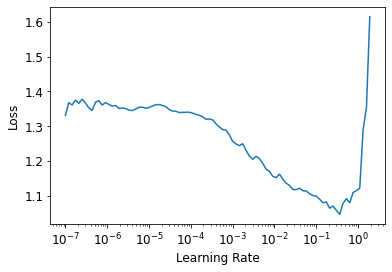

In [79]:
learn.lr_find()

In [85]:
lr = 0.02
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.240898,0.753607,0.848718,00:13


In [86]:
learn.unfreeze()
learn.fit_one_cycle(15, slice(lr/10,lr), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.267297,0.491798,0.876923,00:13
1,0.208960,0.578490,0.866667,00:14
2,0.188273,0.829313,0.879487,00:13
3,0.225947,0.426566,0.887179,00:13
4,0.215490,0.598739,0.871795,00:13
5,0.161672,0.786173,0.851282,00:13
6,0.126598,0.627862,0.864103,00:13
7,0.093515,0.535173,0.884615,00:13
8,0.071850,0.489066,0.884615,00:13
9,0.058632,0.451233,0.887179,00:13


In [87]:
test = """ Ständig unterwegs von Termin zu Termin
Ich halt' es kaum noch aus, nur mit viel Tilidin
Woah, meine Fans sind loyal
Ruf' ich "Sam", dann schrei'n alle "ra"
Ich steh' über den Leuten, unter dem Licht
Herz gefickt, weil ich meine Mutter vermiss'
Und geh' ich von der Stage, dann will ich kein'n seh'n
Er will mir alles hol'n, ich sag' dem Runner, er soll geh'n
Backstage voll mit Energy und Wodka
Und der Notarzt kommt im Helikopter
Die Zeit ist viel zu kostbar, sie wollten mich nur kleinhalten
Doch wer im Glashaus sitzt, sollte nicht mit Stein'n schmeißen
Der Libnani in Giorgio Armani
Kann kaum noch laufen, doch steig' auf die Ducati
Weltunterschiede, der Sheytan im Spiegel
Für viele bin ich leider nur 'ne Gelddruckmaschine
Mitten in der Nacht und ich hasse mich selbst
Was ich gemacht hab' für Geld
Das ist der Grund, warum ich nicht mehr schlafen kann
365 Tage lang
Mitten in der Nacht und ich hasse die Welt
Durch die Stadt im SL, es geht alles zu schnell
Das ist der Grund, warum ich nicht mehr schlafen kann
365 Tage lang
Ich bin im Studio auf Alkohol, das Kokain schmeckt wieder bitter
Ich fang' an zu wein'n, vermisse meine Kinder
Doch nur für euch mach' ich das Para klar
Fünf Songs in einer Nacht, drei Alben in einem Jahr
Nur noch fünf Minuten, dann ist Stagetime
"Papa, wir lieben dich", hör' ich über Facetime
Ich wollt ich selbst bleiben, für euch ein Held sein
Und bin mein'n Weg gegangen, wie bei 8 Mile
Und euer Onkel Ashraf, er mag's nicht, wenn wir ihn erwähn'n
Doch ohne ihn wär ich lang nicht mehr am leben
Echte Freunde zähl' ich an der Hand ab
Ashraf, Samra, Vincent, Heiko Hammer
Danke an alle Fans, ich hab' euch so zu schätzen
Denn nur wegen euch hab' ich heut was zu essen
Und ich scheiß' drauf, was die Hater reden
Ich fall' auf die Knie, um zu Gott zu beten
Mitten in der Nacht und ich hasse mich selbst
Was ich gemacht hab' für Geld
Das ist der Grund, warum ich nicht mehr schlafen kann
365 Tage lang
Mitten in der Nacht und ich hasse die Welt
Durch die Stadt im SL, es geht alles zu schnell
Das ist der Grund, warum ich nicht mehr schlafen kann
365 Tage lang
Kauf' ein'n Lamborghini anthrazit
Kranker Beat, keine Gnade wie Sanssouci
Tage nichts gegessen, fühlt sich an, als würd ich schlafwandeln
Und trotzdem muss ich Hits in den Charts landen
Das alles fickt mein Immunsystem
Draußen warten nur Hyän'n, doch ich bleibe souverän
Ferragamo-Gürtel, sie würden mich gern töten
Tun, als ob sie mich mögen, doch woll'n nur mein Vermögen
Der charmanteste Wichser, arroganteste Junkie
Bin ich mit ihr fertig, kann sie sich wieder anzieh'n
Und der Automat läuft wieder auf Autostart
Endlich Plus, doch ich bin nicht in der Lage auszuzahl'n
Was für anlegen? Hundert K abheben
London, Nachtleben, im Q8 Taş legen
Inhalier'n, denn der Tod ist reserviert
Investier'n, investier'n, und dann alles verlier'n
Mitten in der Nacht und ich hasse mich selbst
Was ich gemacht hab' für Geld
Das ist der Grund, warum ich nicht mehr schlafen kann
365 Tage lang
Mitten in der Nacht und ich hasse die Welt
Durch die Stadt im SL, es geht alles zu schnell
Das ist der Grund, warum ich nicht mehr schlafen kann
365 Tage lang
Mitten in der Nacht und ich hasse mich selbst
Was ich gemacht hab' für Geld
Das ist der Grund, warum ich nicht mehr schlafen kann
It's just me against the world
It's just me against the world (yeah)
Ich hasse die Welt
Fuck the world
Und ich hasse mich selbst
Sometimes it's hard
It's just me against the world
It's just me against the world (yeah)
Ich hasse die Welt
Fuck the world, 'til I'm gone
365 Tage lang """

In [90]:
learn.predict(test)

AttributeError: ignored

## Saving / Exporting the Model for Production Use

In [100]:
learn.export()

In [103]:
from google.colab import files
files.download('/content/models/export.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>